In [ ]:
## Loading the environment
import os

os.getenv('./env')

openAiApiKey = os.getenv('OPENAI_API_KEY')

In [6]:
print("Loading File ./assets/blog_texts.txt")
blog_texts = ''
with open("../assets/blog_texts.txt") as f:
    blog_texts = f.read()


Loading File ./assets/blog_texts.txt


In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter


print("Splitting the file")
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=600, 

    separators=["##########"],
)

# texts = text_splitter.split_text()
print("Creating documents")
documents = text_splitter.create_documents([blog_texts])
print(documents[0:10])


Splitting the file
Creating documents
[Document(page_content='\n\n\nEmplacamentos de veículos crescem 20% no quadrimestre \n\n 3 de maio de 2024\n\n\nEmplacamentos de veículos crescem 20% no quadrimestre. Com 1,4 milhão de unidades emplacadas, setor registra o melhor resultado para os quatro primeiros meses do ano desde 2014.\n\xa0\n\n\n\n\n\nOs emplacamentos de veículos, no mês de abril, registraram alta de 14,4% sobre março, segundo dados divulgados pela FENABRAVE – Federação Nacional da Distribuição de Veículos Automotores. O crescimento se explica não apenas pelo maior número de dias úteis (22 em abril, contra 20 em março), mas também pelo avanço de 4% na média diária de vendas, registrada na comparação entre o terceiro e o quarto mês do ano.\nEm relação a abril do ano passado, houve alta de 38,3% e, no acumulado dos quatro meses, portanto, o aumento foi de 20%.\n“Começamos 2024 confiantes em um crescimento sustentado e este primeiro quadrimestre confirma nossa expectativa. O momen

### Config

In [ ]:
from langchain_openai import ChatOpenAI

fast_llm = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0,
    verbose=True,
  )

long_context_llm =  ChatOpenAI(
    model="gpt-4-turbo-2024-04-09",
    temperature=0,
    verbose=True,
  )


### Generate Initial Outline

In [ ]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Optional
from langchain_core.prompts import ChatPromptTemplate

direct_gen_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a Blog Post writer. Write an outline for a Blog Post page about a user-provided topic. Be comprehensive and specific.",
        ),
        ("user", "{topic}"),
    ]
)


class Subsection(BaseModel):
    subsection_title: str = Field(..., title="Title of the subsection")
    description: str = Field(..., title="Content of the subsection")

    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.description}".strip()


class Section(BaseModel):
    section_title: str = Field(..., title="Title of the section")
    description: str = Field(..., title="Content of the section")
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title="Titles and descriptions for each subsection of the Blog page.",
    )

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            f"### {subsection.subsection_title}\n\n{subsection.description}"
            for subsection in self.subsections or []
        )
        return f"## {self.section_title}\n\n{self.description}\n\n{subsections}".strip()


class Outline(BaseModel):
    page_title: str = Field(..., title="Title of the Blog page")
    sections: List[Section] = Field(
        default_factory=list,
        title="Titles and descriptions for each section of the Blog page.",
    )

    @property
    def as_str(self) -> str:
        sections = "\n\n".join(section.as_str for section in self.sections)
        return f"# {self.page_title}\n\n{sections}".strip()


generate_outline_direct = direct_gen_outline_prompt | fast_llm.with_structured_output(
    Outline
)

In [ ]:
example_topic = "Como se tornar um melhor gestor de frotas"

initial_outline = generate_outline_direct.invoke({"topic": example_topic})

print(initial_outline.as_str)

### Expand Topics

In [ ]:
gen_related_topics_prompt = ChatPromptTemplate.from_template(
    """
    Estou escrevendo uma página de Blog para o assunto abaixo. 
    Por favor identifique e recomende algumas Páginas de Blog sobre assuntos relacionados.
    Estou procurando exemplos que forneçam insights sobre aspectos interessantes comumente associados a este tópico, ou exemplos que me ajudem a entender o conteúdo e a estrutura típicos incluídos nas páginas de Blog para tópicos semelhantes. 
    Por favor liste o máximo de assuntos e urls que você puder.

    Tópico de interesse: {topic}
"""
)


class RelatedSubjects(BaseModel):
    topics: List[str] = Field(
        description="Comprehensive list of related subjects as background research.",
    )


expand_chain = gen_related_topics_prompt | fast_llm.with_structured_output(
    RelatedSubjects
)

In [ ]:
related_subjects = await expand_chain.ainvoke({"topic": example_topic})
related_subjects

### Generate Perspectives

In [ ]:
class Editor(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the editor.",
    )
    name: str = Field(
        description="Name of the editor.", pattern=r"^[a-zA-Z0-9_-]{1,64}$"
    )
    role: str = Field(
        description="Role of the editor in the context of the topic.",
    )
    description: str = Field(
        description="Description of the editor's focus, concerns, and motives.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"


class Perspectives(BaseModel):
    editors: List[Editor] = Field(
        description="Comprehensive list of editors with their roles and affiliations.",
        # Add a pydantic validation/restriction to be at most M editors
    )


gen_perspectives_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            Você precisa selecionar um grupo diversificado (e distinto) de editores de Blog que trabalharão juntos para criar um artigo abrangente sobre o tópico. Cada um deles representa uma perspectiva, papel ou afiliação relacionada a este tópico.
            Você pode usar outras páginas de Blog de tópicos relacionados para se inspirar. Para cada editor, adicione uma descrição do que eles vão focar.

            Páginas de blog para inspiração:
            {examples}""",
        ),
        ("user", "Tópico de interesse: {topic}"),
    ]
)

gen_perspectives_chain = gen_perspectives_prompt | ChatOpenAI(
    model="gpt-3.5-turbo"
).with_structured_output(Perspectives)

In [ ]:
import requests
from bs4 import BeautifulSoup

blog_das_locadoras = []
amount_of_pages = 166

for i in range(amount_of_pages+1):
    url = f"https://blogdaslocadoras.com.br/locadoras-de-veiculos/mercado-de-locacao/page/{i}"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    links = soup.find_all('a')
    for link in links:
        l = link.get('href')
        if '.html' in l:
            if l not in blog_das_locadoras:
                blog_das_locadoras.append(l)

print(blog_das_locadoras)


In [ ]:

blog_texts = []

i = 0
for blog in blog_das_locadoras:
    url = blog
    response = requests.get(url)    
    soup = BeautifulSoup(response.content, 'html.parser')
    texts = soup.select('div.cm-post-content')
    t = texts[0].get_text()
    blog_texts.append(t)
    
    if i != 0 & i % 1000 == 0:
        print("Processed ", i, " blogs out of ", len(blog_das_locadoras))


In [ ]:
# Write the blog texts to a file

with open('blog_texts.txt', 'w') as f:
    for item in blog_texts:
        #  add a ########## to separate the blogs
        f.write("%s\n" % item)
        f.write("##########\n")



Building retriever

In [ ]:
from langchain_openai import OpenAIEmbeddings

from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=600, 
    chunk_overlap=50, 
    separators=["##########", "\n", "\r\n", "\r"],
)

# texts = text_splitter.split_text()
documents = text_splitter.create_documents(blog_texts)
print(len(documents))
db = Chroma.from_documents(documents, OpenAIEmbeddings())

blog_das_locadoras_retriever = db.as_retriever()

In [ ]:
retrieved_docs = await blog_das_locadoras_retriever.abatch(
    related_subjects.topics,
    return_exceptions=True
)

for t in retrieved_docs:
    print(t)

In [84]:
from langchain_core.runnables import RunnableLambda, chain as as_runnable

def format_doc(doc):
    text = ''
    for d in doc:
        if d[1] is not str:
            continue
        text += d[1]
    
    return text
        


def format_docs(docs):
    return "\n\n".join(format_doc(doc) for doc in docs)


@as_runnable
async def survey_subjects(topic: str):
    related_subjects = await expand_chain.ainvoke({"topic": topic})
    retrieved_docs = await blog_das_locadoras_retriever.abatch(
        related_subjects.topics, return_exceptions=True
    )
    all_docs = []
    for docs in retrieved_docs:
        if isinstance(docs, BaseException):
            continue
        all_docs.extend(docs)
    formatted = format_docs(all_docs)
    return await gen_perspectives_chain.ainvoke({"examples": formatted, "topic": topic})
perspectives = await survey_subjects.ainvoke(example_topic)
perspectives.dict()


{'editors': [{'affiliation': 'Universidade de Logística',
   'name': 'AliceLogistica',
   'role': 'Professora de Logística',
   'description': 'Alice é uma especialista em logística com foco em gestão de frotas. Ela irá fornecer informações acadêmicas e teóricas sobre as melhores práticas de gestão de frotas e como os gestores podem melhorar suas habilidades nessa área.'},
  {'affiliation': 'Empresa de Tecnologia para Logística',
   'name': 'BobTechLog',
   'role': 'Especialista em Tecnologia para Logística',
   'description': 'Bob é especialista em tecnologia para logística e irá abordar como as soluções tecnológicas podem auxiliar os gestores de frotas a aprimorar sua eficiência e desempenho.'},
  {'affiliation': 'Empresa de Transporte e Logística',
   'name': 'CharlieTranspLog',
   'role': 'Gestor de Frota',
   'description': 'Charlie tem experiência prática como gestor de frota e irá compartilhar insights e dicas práticas baseadas em sua experiência no campo.'}]}

### Expert Dialog

In [85]:
from langgraph.graph import StateGraph, END
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated, Sequence


def add_messages(left, right):
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    return left + right


def update_references(references, new_references):
    if not references:
        references = {}
    references.update(new_references)
    return references


def update_editor(editor, new_editor):
    # Can only set at the outset
    if not editor:
        return new_editor
    return editor


class InterviewState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    references: Annotated[Optional[dict], update_references]
    editor: Annotated[Optional[Editor], update_editor]

In [88]:
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage


gen_qn_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            Você é um escritor experiente de Blog e deseja editar uma página específica. \
            Além de sua identidade como escritor de Blog, você tem um foco específico ao pesquisar o tópico. \
Agora, você está conversando com um especialista para obter informações. Faça boas perguntas para obter informações mais úteis.

Quando você não tiver mais perguntas a fazer, diga "Muito obrigado pela sua ajuda!" para encerrar a conversa.\
Por favor, faça apenas uma pergunta de cada vez e não pergunte o que você já perguntou antes.\
Suas perguntas devem estar relacionadas ao tópico que você deseja escrever.
Seja abrangente e curioso, obtendo o máximo de informações exclusivas do especialista possível.\

Mantenha-se fiel à sua perspectiva específica:

{persona}""",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)


def tag_with_name(ai_message: AIMessage, name: str):
    ai_message.name = name
    return ai_message


def swap_roles(state: InterviewState, name: str):
    converted = []
    for message in state["messages"]:
        if isinstance(message, AIMessage) and message.name != name:
            message = HumanMessage(**message.dict(exclude={"type"}))
        converted.append(message)
    return {"messages": converted}


@as_runnable
async def generate_question(state: InterviewState):
    editor = state["editor"]
    gn_chain = (
        RunnableLambda(swap_roles).bind(name=editor.name)
        | gen_qn_prompt.partial(persona=editor.persona)
        | fast_llm
        | RunnableLambda(tag_with_name).bind(name=editor.name)
    )
    result = await gn_chain.ainvoke(state)
    return {"messages": [result]}

In [95]:
messages = [
    HumanMessage(f"Então você está escrevendo um artigo sobre {example_topic}?")
]
question = await generate_question.ainvoke(
    {
        "editor": perspectives.editors[0],
        "messages": messages,
    }
)

question["messages"][0].content

'Sim, estou escrevendo um artigo sobre como se tornar um melhor gestor de frotas. Como especialista em logística e gestão de frotas, estou buscando informações acadêmicas e teóricas para ajudar os gestores a aprimorar suas habilidades nessa área. Você poderia me fornecer algumas dicas práticas e estratégias que os gestores de frotas podem implementar para melhorar seu desempenho e eficiência?'

Answer questions

In [93]:
class Queries(BaseModel):
    queries: List[str] = Field(
        description="Comprehensive list of search engine queries to answer the user's questions.",
    )


gen_queries_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Você é um assistente de pesquisa muito útil. Consulte o mecanismo de pesquisa para responder às perguntas do usuário.",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)
gen_queries_chain = gen_queries_prompt | ChatOpenAI(
    model="gpt-3.5-turbo"
).with_structured_output(Queries, include_raw=True)

In [96]:
queries = await gen_queries_chain.ainvoke(
    {"messages": [HumanMessage(content=question["messages"][0].content)]}
)
queries["parsed"].queries

['dicas práticas para gestores de frotas',
 'estratégias para melhorar desempenho de gestão de frotas',
 'como se tornar um melhor gestor de frotas',
 'habilidades necessárias para gestores de frotas']

In [97]:
class AnswerWithCitations(BaseModel):
    answer: str = Field(
        description="Comprehensive answer to the user's question with citations.",
    )
    cited_urls: List[str] = Field(
        description="List of urls cited in the answer.",
    )

    @property
    def as_str(self) -> str:
        return f"{self.answer}\n\nCitations:\n\n" + "\n".join(
            f"[{i+1}]: {url}" for i, url in enumerate(self.cited_urls)
        )


gen_answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
                Você é um especialista que pode usar informações efetivamente. 
                Você está conversando com um escritor de Blog que deseja escrever uma página de Blog sobre o tópico que você conhece. 
                Você reuniu as informações relacionadas e agora usará as informações para formar uma resposta.

                Garanta que sua resposta seja informativa e que cada frase seja apoiada pelas informações coletadas.
                Cada resposta deve ser apoiada por uma citação de uma fonte confiável, formatada como uma nota de rodapé, reproduzindo as URLS após sua resposta.
            """,
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

gen_answer_chain = gen_answer_prompt | fast_llm.with_structured_output(
    AnswerWithCitations, include_raw=True
).with_config(run_name="GenerateAnswer")

In [100]:
from langchain_community.utilities.duckduckgo_search import DuckDuckGoSearchAPIWrapper
from langchain_core.tools import tool

# DDG 
search_engine = DuckDuckGoSearchAPIWrapper()

@tool
async def search_engine(query: str):
    """Search engine to the internet."""
    results = DuckDuckGoSearchAPIWrapper()._ddgs_text(query)
    return [{"content": r["body"], "url": r["href"]} for r in results]

In [101]:
from langchain_core.runnables import RunnableConfig
import json


async def gen_answer(
    state: InterviewState,
    config: Optional[RunnableConfig] = None,
    name: str = "Subject_Matter_Expert",
    max_str_len: int = 15000,
):
    swapped_state = swap_roles(state, name)  # Convert all other AI messages
    queries = await gen_queries_chain.ainvoke(swapped_state)
    query_results = await search_engine.abatch(
        queries["parsed"].queries, config, return_exceptions=True
    )
    successful_results = [
        res for res in query_results if not isinstance(res, Exception)
    ]
    all_query_results = {
        res["url"]: res["content"] for results in successful_results for res in results
    }
    # We could be more precise about handling max token length if we wanted to here
    dumped = json.dumps(all_query_results)[:max_str_len]
    ai_message: AIMessage = queries["raw"]
    tool_call = queries["raw"].additional_kwargs["tool_calls"][0]
    tool_id = tool_call["id"]
    tool_message = ToolMessage(tool_call_id=tool_id, content=dumped)
    swapped_state["messages"].extend([ai_message, tool_message])
    # Only update the shared state with the final answer to avoid
    # polluting the dialogue history with intermediate messages
    generated = await gen_answer_chain.ainvoke(swapped_state)
    cited_urls = set(generated["parsed"].cited_urls)
    # Save the retrieved information to a the shared state for future reference
    cited_references = {k: v for k, v in all_query_results.items() if k in cited_urls}
    formatted_message = AIMessage(name=name, content=generated["parsed"].as_str)
    return {"messages": [formatted_message], "references": cited_references}

In [102]:
example_answer = await gen_answer(
    {"messages": [HumanMessage(content=question["messages"][0].content)]}
)
example_answer["messages"][-1].content

'Para melhorar o desempenho e eficiência na gestão de frotas, os gestores podem implementar diversas práticas e estratégias. Alguns pontos-chave incluem: 1. Gerenciamento eficaz dos insumos, como combustíveis e peças, para reduzir desperdícios e otimizar recursos[1]. 2. Otimização do uso de veículos, garantindo disponibilidade quando necessário e uso eficiente[2]. 3. Utilização de sistemas de gestão de frotas para reduzir custos de entrega e melhorar a qualidade do serviço[3]. 4. Adoção de práticas sustentáveis, como o uso de biocombustíveis, para uma gestão mais econômica e alinhada com a sustentabilidade[4]. Além disso, habilidades essenciais para gestores de frotas incluem organização, domínio dos processos, gerenciamento financeiro, controle de custos operacionais e busca por eficiência[5][6].\n\nCitations:\n\n[1]: https://tl.trimble.com/blog/melhores-praticas-gestao-de-frotas/\n[2]: https://frota162.com.br/blog/gestao-de-frotas/\n[3]: https://www.totvs.com/blog/gestao-para-rotas/g

### Graph Interview

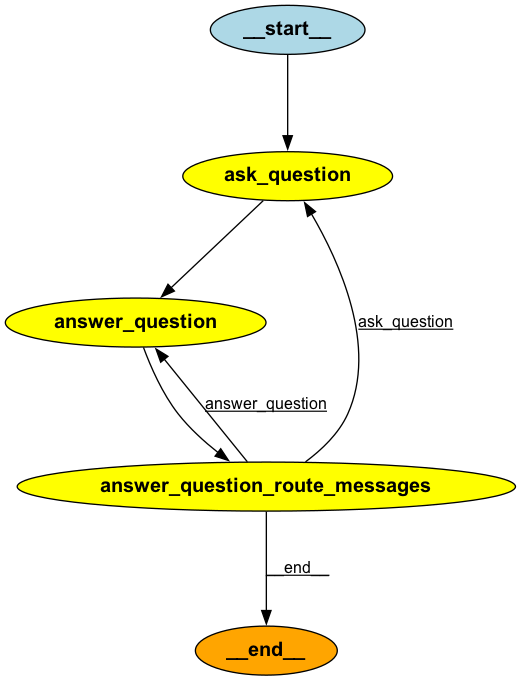

In [104]:
from IPython.display import Image

max_num_turns = 5

def route_messages(state: InterviewState, name: str = "Subject_Matter_Expert"):
    messages = state["messages"]
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )
    if num_responses >= max_num_turns:
        return END
    last_question = messages[-2]
    if last_question.content.endswith("Thank you so much for your help!"):
        return END
    return "ask_question"


builder = StateGraph(InterviewState)

builder.add_node("ask_question", generate_question)
builder.add_node("answer_question", gen_answer)
builder.add_conditional_edges("answer_question", route_messages)
builder.add_edge("ask_question", "answer_question")

builder.set_entry_point("ask_question")
interview_graph = builder.compile().with_config(run_name="Conduct Interviews")

# Feel free to comment out if you have
# not installed pygraphviz
Image(interview_graph.get_graph().draw_png())

In [105]:
final_step = None

initial_state = {
    "editor": perspectives.editors[0],
    "messages": [
        AIMessage(
            content=f"So you said you were writing an article on {example_topic}?",
            name="Subject_Matter_Expert",
        )
    ],
}
async for step in interview_graph.astream(initial_state):
    name = next(iter(step))
    print(name)
    print("-- ", str(step[name]["messages"])[:300])
    if END in step:
        final_step = step

ask_question
--  [AIMessage(content='Sim, estou escrevendo um artigo sobre como se tornar um melhor gestor de frotas. Você poderia me fornecer algumas dicas práticas e teóricas sobre como os gestores de frotas podem melhorar suas habilidades nessa área?', response_metadata={'token_usage': {'completion_tokens': 59, '
answer_question
--  [AIMessage(content='Para se tornar um melhor gestor de frotas, é essencial apostar na tecnologia, utilizando sistemas de rastreamento, telemetria e softwares de gestão de frotas para tomar decisões informadas[1]. Além disso, um bom gestor de frota deve ter habilidades de gerenciamento financeiro, ad
ask_question
--  [AIMessage(content='Essas são informações valiosas e muito úteis para o meu artigo. Gostaria de saber se você tem alguma sugestão adicional sobre como os gestores de frotas podem aprimorar suas habilidades de liderança e comunicação para lidar eficazmente com desafios e situações do dia a dia?', res
answer_question
--  [AIMessage(content='Par

In [106]:
final_state = next(iter(final_step.values()))

### Refine Outline


In [107]:
refine_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            Você é um escritor de Blog. Você reuniu informações de especialistas e mecanismos de busca. Agora, você está refinando a estrutura da página do Blog. \
            Você precisa garantir que o esboço seja  específico. \
            Tópico que você está escrevendo: {topic}
            Aqui está o esboço inicial que você escreveu:

            {old_outline}
        """,
        ),
        (
            "user",
            "Refine a estrutura com base em suas conversas com especialistas no assunto:\n\nConversas:\n\n{conversations}\n\nEscreva o esboço refinado da página de Blog:",
        ),
    ]
)

# Using turbo preview since the context can get quite long
refine_outline_chain = refine_outline_prompt | long_context_llm.with_structured_output(
    Outline
)

In [108]:
refined_outline = refine_outline_chain.invoke(
    {
        "topic": example_topic,
        "old_outline": initial_outline.as_str,
        "conversations": "\n\n".join(
            f"### {m.name}\n\n{m.content}" for m in final_state["messages"]
        ),
    }
)


In [109]:
print(refined_outline.as_str)

# Como se tornar um melhor gestor de frotas

## Introdução

Breve introdução sobre a importância da gestão de frotas e como um bom gestor pode impactar positivamente a eficiência e os custos da operação.

## Habilidades e Conhecimentos Necessários

Lista das habilidades e conhecimentos essenciais para se tornar um bom gestor de frotas, como conhecimento técnico de veículos, habilidades de liderança, capacidade de planejamento, entre outros.

### Gestão Financeira

Desenvolvimento de habilidades para gerenciar custos operacionais e planejar despesas futuras.

### Gestão de Pessoas

Motivação e desenvolvimento da equipe para garantir o bom funcionamento da frota.

### Treinamento de Motoristas

Implementação de planos de treinamento para melhorar as habilidades e conhecimentos dos motoristas sobre a operação da frota.

## Estratégias de Gestão Eficientes

Exploração de estratégias eficientes de gestão de frotas, como manutenção preventiva, otimização de rotas, controle de custos, gestão 

### Generate Article

In [120]:
from langchain_core.documents import Document

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
reference_docs = [
    Document(page_content=v, metadata={"source": k}) for k, v in final_state["references"].items()
]

# This really doesn't need to be a vectorstore for this size of data.
# It could just be a numpy matrix. Or you could store documents
# across requests if you want.
vectorstore = Chroma.from_documents(reference_docs, embeddings)
retriever = vectorstore.as_retriever(k=10)

retriever.invoke("Como se tornar um melhor gestor de frotas")

[Document(page_content='No comunicado feito para anunciar a compra, publicado no dia 27 deste mês, a Simpar apontou que as expertises da Truckpad darão “aceleração do desenvolvimento tecnológico da JSL”.\n\n\n\n\n\nFonte:\xa0trademap.com.br\nSimpar adquire Grupo Green\n\n\nSobre a Simpar'),
 Document(page_content='No comunicado feito para anunciar a compra, publicado no dia 27 deste mês, a Simpar apontou que as expertises da Truckpad darão “aceleração do desenvolvimento tecnológico da JSL”.\n\n\n\n\n\nFonte:\xa0trademap.com.br\nSimpar adquire Grupo Green\n\n\nSobre a Simpar'),
 Document(page_content='A Simpar controla também a Movida (MOVI3), de aluguel de carros, a Vamos (VAMO3), de caminhões e máquinas, e a JSL (JSLG3), de logística e transporte rodoviário.\n\xa0\n\n\n\n\n\n\nSimpar compra Grupo Alta por R$ 120,8 milhões\n\nA\xa0Simpar comprou o Grupo Alta por R$ 120,8 milhões,\xa0conforme comunicado pela companhia no início do mês. A operação da Simpar está prevista para ter pagamen

Generate Sections

In [121]:
class SubSection(BaseModel):
    subsection_title: str = Field(..., title="Title of the subsection")
    content: str = Field(
        ...,
        title="Full content of the subsection. Include [#] citations to the cited sources where relevant.",
    )

    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.content}".strip()


class BlogSection(BaseModel):
    section_title: str = Field(..., title="Title of the section")
    content: str = Field(..., title="Full content of the section")
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title="Titles and descriptions for each subsection of the Wikipedia page.",
    )
    citations: List[str] = Field(default_factory=list)

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            subsection.as_str for subsection in self.subsections or []
        )
        citations = "\n".join([f" [{i}] {cit}" for i, cit in enumerate(self.citations)])
        return (
            f"## {self.section_title}\n\n{self.content}\n\n{subsections}".strip()
            + f"\n\n{citations}".strip()
        )


section_writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Você é um ótimo escritor de Blog. Complete o texto do seu Blog a partir do seguinte esboço:\n\n{outline}\n\nCite suas fontes, usando as seguintes referências:\n\n<Documentos>\n{docs}\n<Documentos>",
        ),
        ("user", "Escreva o texto completo para a seção {section}."),
    ]
)


async def retrieve(inputs: dict):
    docs = await retriever.ainvoke(inputs["topic"] + ": " + inputs["section"])

    formatted = "\n".join(
        [
            f'<Document"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )
    return {"docs": formatted, **inputs}


section_writer = (
    retrieve
    | section_writer_prompt
    | long_context_llm.with_structured_output(BlogSection)
)

section = await section_writer.ainvoke(
    {
        "outline": refined_outline.as_str,
        "section": refined_outline.sections[1].section_title,
        "topic": example_topic,
    }
)
print(section.as_str)

[Document(page_content='O setor do turismo foi um dos mais afetados pelo isolamento social como forma de combate ao novo coronavírus. O dinheiro poderá ser utilizado para auxiliar em projetos, equipamentos e capital de giro. O objetivo é proporcionar condições de manter as empresas e os empregos que elas geram até o retorno das vendas.'), Document(page_content='Trata-se de uma excelente parceria que conta com protagonistas da mais alta relevância para os pequenos negócios do turismo como Prefeitura Municipal de Porto Velho, Fecomércio Rondônia, Associação Brasileira de Bares e Restaurantes de Rondônia (Abrasel RO), Associação Brasileira de Agentes de Viagens de Rondônia (ABAV), Associação Brasileira da Indústria de Hotéis (ABIH) e Associação Brasileira das Locadoras de Automóveis (ABLA).'), Document(page_content='Por outro lado, Moisés revelou que ainda não há uma previsão para liberação de missas e cultos. “Ainda estão com restrição de acontecer pois ainda não temos uma metodologia se

Generating the final article

In [133]:
from langchain_core.output_parsers import StrOutputParser

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Você é um ótimo autor de Blog. Escreva um texto completo de Blog sobre {topic} usando os seguinte rascunho de seções:\n\n{draft}\n\nSiga estritamente as diretrizes de formato: Image - Data - Conteúdo - Referências.",
        ),
        (
            "user",
            "Escreva um artigo completo usando o formato markdown. Organize as citações usando notas de rodapé como '[1]'.",
        ),
    ]
)

writer = writer_prompt | long_context_llm | StrOutputParser()

In [123]:
for tok in writer.stream({"topic": example_topic, "draft": section.as_str}):
    print(tok, end="")

# Como se Tornar um Melhor Gestor de Frotas

![Gestão de Frotas](https://example.com/image-url)

**Data:** 10 de Outubro de 2023

A gestão de frotas é uma área que exige uma ampla gama de habilidades e conhecimentos, abrangendo desde a administração financeira até a gestão de pessoas e a segurança dos motoristas. Neste artigo, exploraremos as competências essenciais para se tornar um gestor de frotas mais eficiente e eficaz.

## Habilidades e Conhecimentos Necessários

Para se destacar na gestão de frotas, é crucial desenvolver tanto habilidades técnicas quanto interpessoais. A seguir, detalhamos algumas das competências mais importantes:

### Gestão Financeira

A capacidade de gerenciar os custos operacionais de forma eficiente é fundamental para qualquer gestor de frotas. Isso inclui não apenas o controle dos gastos com combustível e manutenção, mas também a habilidade de planejar despesas futuras e realizar análises de custo-benefício para investimentos em novos veículos ou tecnolog

## Final Flow

In [124]:
class ResearchState(TypedDict):
    topic: str
    outline: Outline
    editors: List[Editor]
    interview_results: List[InterviewState]
    # The final sections output
    sections: List[BlogSection]
    article: str

In [125]:
import asyncio


async def initialize_research(state: ResearchState):
    topic = state["topic"]
    coros = (
        generate_outline_direct.ainvoke({"topic": topic}),
        survey_subjects.ainvoke(topic),
    )
    results = await asyncio.gather(*coros)
    return {
        **state,
        "outline": results[0],
        "editors": results[1].editors,
    }


async def conduct_interviews(state: ResearchState):
    topic = state["topic"]
    initial_states = [
        {
            "editor": editor,
            "messages": [
                AIMessage(
                    content=f"Você disse que estava escrevendo um texto de Blog sobre {topic}?",
                    name="Subject_Matter_Expert",
                )
            ],
        }
        for editor in state["editors"]
    ]
    # We call in to the sub-graph here to parallelize the interviews
    interview_results = await interview_graph.abatch(initial_states)

    return {
        **state,
        "interview_results": interview_results,
    }


def format_conversation(interview_state):
    messages = interview_state["messages"]
    convo = "\n".join(f"{m.name}: {m.content}" for m in messages)
    return f'Conversa com {interview_state["editor"].name}\n\n' + convo


async def refine_outline(state: ResearchState):
    convos = "\n\n".join(
        [
            format_conversation(interview_state)
            for interview_state in state["interview_results"]
        ]
    )

    updated_outline = await refine_outline_chain.ainvoke(
        {
            "topic": state["topic"],
            "old_outline": state["outline"].as_str,
            "conversations": convos,
        }
    )
    return {**state, "outline": updated_outline}


async def index_references(state: ResearchState):
    all_docs = []
    for interview_state in state["interview_results"]:
        reference_docs = [
            Document(page_content=v, metadata={"source": k})
            for k, v in interview_state["references"].items()
        ]
        all_docs.extend(reference_docs)
    await vectorstore.add_documents(all_docs)
    return state


async def write_sections(state: ResearchState):
    outline = state["outline"]
    sections = await section_writer.abatch(
        [
            {
                "outline": refined_outline.as_str,
                "section": section.section_title,
                "topic": state["topic"],
            }
            for section in outline.sections
        ]
    )
    return {
        **state,
        "sections": sections,
    }


async def write_article(state: ResearchState):
    topic = state["topic"]
    sections = state["sections"]
    draft = "\n\n".join([section.as_str for section in sections])
    article = await writer.ainvoke({"topic": topic, "draft": draft})
    return {
        **state,
        "article": article,
    }

In [126]:
builder_of_storm = StateGraph(ResearchState)

nodes = [
    ("init_research", initialize_research),
    ("conduct_interviews", conduct_interviews),
    ("refine_outline", refine_outline),
    ("index_references", index_references),
    ("write_sections", write_sections),
    ("write_article", write_article),
]
for i in range(len(nodes)):
    name, node = nodes[i]
    builder_of_storm.add_node(name, node)
    if i > 0:
        builder_of_storm.add_edge(nodes[i - 1][0], name)

builder_of_storm.set_entry_point(nodes[0][0])
builder_of_storm.set_finish_point(nodes[-1][0])
storm = builder_of_storm.compile()

In [135]:
async for step in storm.astream(
    {
        "topic": """
            Quais as melhores maneiras de escolher um locatário?

            ----
            Aborde os tópicos:
            - Análise Criminal
            - Análise Financeira
            - Análise Biométrica
            - Tendências
        """,
    }
):
    name = next(iter(step))
    print(name)
    print("-- ", str(step[name])[:300])
    if END in step:
        results = step
































init_research
--  {'topic': '\n            Quais as melhores maneiras de escolher um locatário?\n\n            ----\n            Aborde os tópicos:\n            - Análise Criminal\n            - Análise Financeira\n            - Análise Biométrica\n            - Tendências\n        ', 'outline': Outline(page_title='C
conduct_interviews
--  {'topic': '\n            Quais as melhores maneiras de escolher um locatário?\n\n            ----\n            Aborde os tópicos:\n            - Análise Criminal\n            - Análise Financeira\n            - Análise Biométrica\n            - Tendências\n        ', 'outline': Outline(page_title='C
refine_outline
--  {'topic': '\n            Quais as melhores maneiras de escolher um locatário?\n\n            ----\n            Aborde os tópicos:\n            - Análise Criminal\n            - Análise Financeira\n            - Análise Biométrica\n            - Tendências\n        ', 'outline': Outline(page_title='C
index_

In [136]:
article = results[END]["article"]


In [137]:
article

'# Como Escolher o Locatário Ideal para Seu Imóvel\n\nA escolha de um locatário adequado é uma das decisões mais importantes que proprietários de imóveis devem fazer. Um bom locatário pode garantir a rentabilidade e a manutenção do imóvel, enquanto uma escolha inadequada pode resultar em prejuízos e dores de cabeça. Este artigo aborda as melhores práticas para selecionar um locatário, incluindo análise criminal, financeira, biométrica e tendências do mercado.\n\n## Análise Criminal\n\nA análise criminal é fundamental para garantir a segurança e a integridade do imóvel. Verificar o histórico criminal do potencial locatário pode prevenir problemas futuros, como condutas impróprias ou até atividades ilegais no imóvel. É recomendável utilizar serviços de verificação de antecedentes que incluam registros nacionais e internacionais, se aplicável.\n\n### Técnicas de Análise\n\nUtilize bases de dados confiáveis para a consulta de antecedentes criminais. Além disso, é possível solicitar ao cand

'# Como Evitar Fraudes em uma Locadora de Veículos?\n\n## Introdução\n\nA gestão de frotas é um componente crucial para empresas que dependem de veículos para operações diárias, como transporte, logística e distribuição. Um gestor de frotas eficaz não apenas garante que os veículos estejam operacionais, mas também desempenha um papel fundamental na redução de custos e no aumento da eficiência geral da operação. Através de uma gestão estratégica, é possível otimizar o uso dos veículos, melhorar a segurança e a satisfação dos motoristas, e garantir a conformidade com as regulamentações ambientais e de segurança. Portanto, desenvolver habilidades e adotar práticas eficazes de gestão de frotas pode ter um impacto significativo no sucesso e na sustentabilidade de uma empresa.\n\n## Verificação de Documentos\n\nA verificação de documentos é um aspecto crucial na gestão de frotas, especialmente para empresas que lidam com aluguel de veículos. Esta prática ajuda a prevenir fraudes e garantir que apenas indivíduos qualificados e autorizados tenham acesso aos veículos. A autenticidade dos documentos de identidade, licenças de condução e outros documentos relevantes deve ser rigorosamente verificada antes de permitir o aluguel ou uso de um veículo.\n\n### Identidades Falsas\n\nGolpistas podem utilizar documentos de identidade falsificados para alugar veículos. É essencial verificar rigorosamente a autenticidade dos documentos para evitar tais fraudes. Empresas como a Eloca têm implementado sistemas avançados de verificação para combater esse problema[1].\n\n## Monitoramento por Câmeras\n\nO monitoramento por câmeras é uma prática cada vez mais adotada na gestão de frotas, proporcionando uma série de benefícios tanto para a segurança quanto para a eficiência operacional. A instalação de câmeras nos veículos permite uma vigilância constante, o que ajuda a prevenir comportamentos inadequados dos motoristas, como direção perigosa ou uso não autorizado do veículo.\n\n### Vantagens do Monitoramento por Câmeras\n\n1. Prevenção de comportamentos inadequados dos motoristas.\n2. Auxílio na gestão de tráfego e otimização de rotas.\n3. Fornecimento de evidências em casos de acidentes.\n4. Melhoria na segurança geral da frota.\n5. Monitoramento em tempo real das operações.\n\n## Auditorias Internas\n\nAs auditorias internas são uma parte crucial da gestão de frotas, proporcionando uma revisão sistemática das operações e práticas. Essas auditorias ajudam a identificar áreas de melhoria, garantir conformidade com regulamentos e leis, e assegurar que os procedimentos de segurança estão sendo seguidos adequadamente. A realização regular de auditorias internas permite que os gestores de frotas mantenham um controle rigoroso sobre a eficiência operacional, custos e riscos associados à gestão da frota.\n\n### Planejamento e Execução\n\nO planejamento cuidadoso é essencial para a realização eficaz de uma auditoria interna. Isso inclui a definição de objetivos claros, a escolha de uma equipe competente para a auditoria e a programação de auditorias em intervalos regulares. A execução deve ser meticulosa, com a equipe de auditoria examinando meticulosamente todos os aspectos relevantes das operações da frota.\n\n### Relatório e Ação\n\nApós a conclusão da auditoria, é crucial que um relatório detalhado seja preparado, destacando as descobertas e recomendando ações corretivas. Este relatório deve ser revisto pela gestão sênior e medidas devem ser implementadas para abordar quaisquer deficiências identificadas. A transparência e a responsabilidade são fundamentais para garantir que as ações recomendadas sejam efetivamente implementadas.\n\n## Treinamento de Motoristas\n\nO treinamento eficaz dos motoristas é crucial para a operação segura e eficiente de qualquer frota. Um programa de treinamento bem estruturado não apenas melhora as habilidades de condução, mas também garante que os motoristas estejam atualizados com as melhores práticas de segurança e manutenção do veículo. Além disso, o treinamento pode ajudar a reduzir custos operacionais, minimizando o desgaste dos veículos e o consumo de combustível.\n\n### Desenvolvimento de Programas de Treinamento\n\nOs gestores de frotas devem desenvolver programas de treinamento que abordem tanto as habilidades técnicas quanto as comportamentais. Isso inclui desde a operação segura do veículo até a gestão do tempo e o atendimento ao cliente. É importante que o treinamento seja contínuo e adaptado às necessidades específicas da frota e dos motoristas.\n\n### Uso de Tecnologia no Treinamento\n\nA tecnologia pode ser uma aliada importante no treinamento de motoristas. Simuladores de direção, por exemplo, oferecem uma maneira segura e controlada para os motoristas praticarem e aprimorarem suas habilidades sem os riscos associados à condução na estrada. Além disso, plataformas de aprendizado online permitem que os treinamentos sejam mais flexíveis e acessíveis.\n\n### Avaliação e Feedback\n\nAvaliar o desempenho dos motoristas após o treinamento é essencial para garantir a eficácia do programa. Feedbacks regulares e construtivos ajudam a identificar áreas de melhoria e a reforçar os comportamentos positivos. Isso não só melhora a competência dos motoristas, mas também contribui para a sua motivação e engajamento com a empresa.\n\n## Políticas de Segurança\n\nA segurança é um dos pilares fundamentais na gestão de frotas. Implementar políticas de segurança robustas não só protege os motoristas e veículos, mas também reduz custos operacionais relacionados a acidentes e danos. Uma política de segurança eficaz deve abranger diversos aspectos, desde o comportamento do motorista até a manutenção preventiva dos veículos.\n\n### Comportamento do Motorista\n\nFocar na educação e monitoramento contínuo dos motoristas para promover práticas de direção segura e responsável.\n\n### Manutenção Preventiva\n\nImplementar um programa de manutenção regular para garantir que todos os veículos estejam em condições seguras de operação.\n\n### Uso de Tecnologia\n\nAdotar tecnologias avançadas para melhorar a segurança e eficiência da frota, como sistemas de rastreamento e telemetria.\n\n---\n\nReferências:\n[1]: https://www.eloca.com/sistemas-de-verificacao'

In [138]:
from IPython.display import Markdown

Markdown(article.replace("\n#", "\n##"))


with open('article.md', 'w') as f:
    f.write(article)


In [2]:
pip install taipy

  Using cached taipy-3.1.1-py3-none-any.whl.metadata (9.6 kB)
  Using cached cookiecutter-2.5.0-py3-none-any.whl.metadata (7.3 kB)
  Using cached taipy_gui-3.1.2-py3-none-any.whl
  Using cached taipy_rest-3.1.1-py3-none-any.whl
  Using cached taipy_templates-3.1.1-py3-none-any.whl
  Using cached binaryornot-0.4.4-py2.py3-none-any.whl.metadata (6.0 kB)
  Using cached python_slugify-8.0.4-py2.py3-none-any.whl.metadata (8.5 kB)
  Using cached arrow-1.3.0-py3-none-any.whl.metadata (7.5 kB)
  Using cached Flask_Cors-4.0.0-py2.py3-none-any.whl.metadata (5.4 kB)
  Using cached Flask_SocketIO-5.3.6-py3-none-any.whl.metadata (2.6 kB)
  Using cached gevent-23.9.1-cp312-cp312-macosx_11_0_universal2.whl.metadata (13 kB)
  Using cached gevent_websocket-0.10.1-py3-none-any.whl.metadata (5.3 kB)
  Using cached gitignore_parser-0.1.11-py3-none-any.whl
  Using cached kthread-0.2.3-py3-none-any.whl.metadata (2.2 kB)
  Using cached Markdown-3.5.2-py3-none-any.whl.metadata (7.0 kB)
  Using cached pandas-2

[2024-05-04 14:52:04][Taipy][INFO] Running in 'single_client' mode in notebook environment


ConnectionError: Port 5000 is already opened on 127.0.0.1. You have another server application running on the same port.